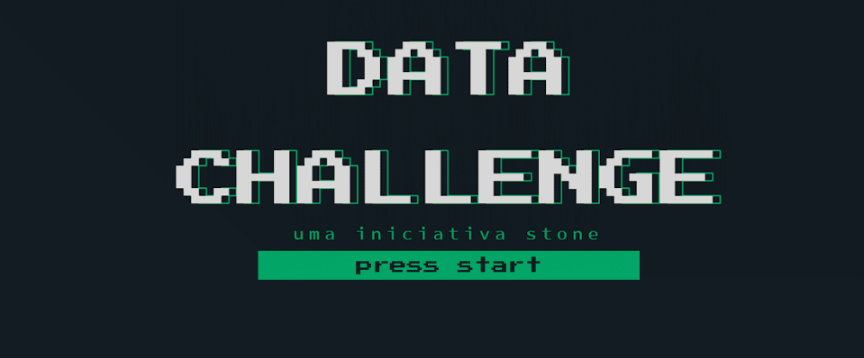

In [2]:
Image( '../../images/data_challenge.png')

# 0.0. IMPORTS

In [3]:
import pandas   as pd
import seaborn  as sns

from IPython.display       import Image
from IPython.core.display  import HTML

## 0.1. Aux Functions

In [4]:
# jupyter design
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 15

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.4f}'.format
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Datasets

In [5]:
df_portfolio_clientes = pd.read_csv( '../../datasets/datasets_transformados/portfolio_clientes_final.csv' )
df_portfolio_comunicados = pd.read_csv( '../../datasets/datasets_transformados/portfolio_comunicados_final.csv' )
df_portfolio_geral_tpv = pd.read_csv( '../../datasets/datasets_transformados/portfolio_geral_tpv_final.csv' )

# Convertendo colunas de data pra datetime pois quando se exporta pra csv elas voltam para float

# ---- Portfolio Comunicados ----- #

# dt_ref_portfolio
df_portfolio_comunicados['dt_ref_portfolio'] = pd.to_datetime( df_portfolio_comunicados['dt_ref_portfolio'] )

# data_acao
df_portfolio_comunicados['data_acao'] = pd.to_datetime( df_portfolio_comunicados['data_acao'] )

# ---- Portfolio Geral TPV ----- #

# dt_ref_portfolio
df_portfolio_geral_tpv['dt_ref_portfolio']= pd.to_datetime( df_portfolio_geral_tpv['dt_ref_portfolio'] )

# safra
df_portfolio_geral_tpv['safra']= pd.to_datetime( df_portfolio_geral_tpv['safra'], format='%Y-%m' )

# dt_contrato
df_portfolio_geral_tpv['dt_contrato']= pd.to_datetime( df_portfolio_geral_tpv['dt_contrato'] )

# dt_desembolso
df_portfolio_geral_tpv['dt_desembolso']= pd.to_datetime( df_portfolio_geral_tpv['dt_desembolso'] )

# dt_vencimento
df_portfolio_geral_tpv['dt_vencimento']= pd.to_datetime( df_portfolio_geral_tpv['dt_vencimento'] )

# dt_wo
df_portfolio_geral_tpv['dt_wo']= pd.to_datetime( df_portfolio_geral_tpv['dt_wo'] )

In [6]:
# merge no portfolio geral tpv com o de clientes, 2 clientes excluídos por não terem cidade nem estado
df_geral_tpv_clientes = df_portfolio_geral_tpv.merge( df_portfolio_clientes, on='nr_documento', how='left' )
df_geral_tpv_clientes = df_geral_tpv_clientes.dropna()

# merge df aux com df comunicados formando df all - o objetivo aqui é filtrar apenas 
# as linhas do novo datafram que tiveram comunicados e formar um conjunto de dados só, com todas as informações
df_all = df_geral_tpv_clientes.merge( df_portfolio_comunicados, left_on=['contrato_id','dt_ref_portfolio'], right_on=['contrato_id','data_acao'], how='inner' )

df_all = df_all.rename( columns={'dt_ref_portfolio_x':'dt_ref_portfolio','dt_ref_portfolio_y':'dt_mensagem_originada'})
df_all = df_all.drop( columns=['data_acao'] )

In [12]:
df_geral_tpv_clientes.to_csv('../../datasets/datasets_transformados/df_geral_tpv_clientes.csv')

# 1.0. Análise Exploratória de Dados

In [7]:
# agrupamento df_all por contrato
df = df_all[['contrato_id','dt_ref_portfolio','acao','status','status_contrato','dsp','dspp','vlr_saldo_devedor']].groupby(['contrato_id','dt_ref_portfolio','acao','status','status_contrato','dsp','dspp']).max().reset_index()

## Distribuição da Ação X Densidade de valores da ação em relação ao saldo devedor
## Distribuição do Status X Densidade de valores do status em relação ao saldo devedor

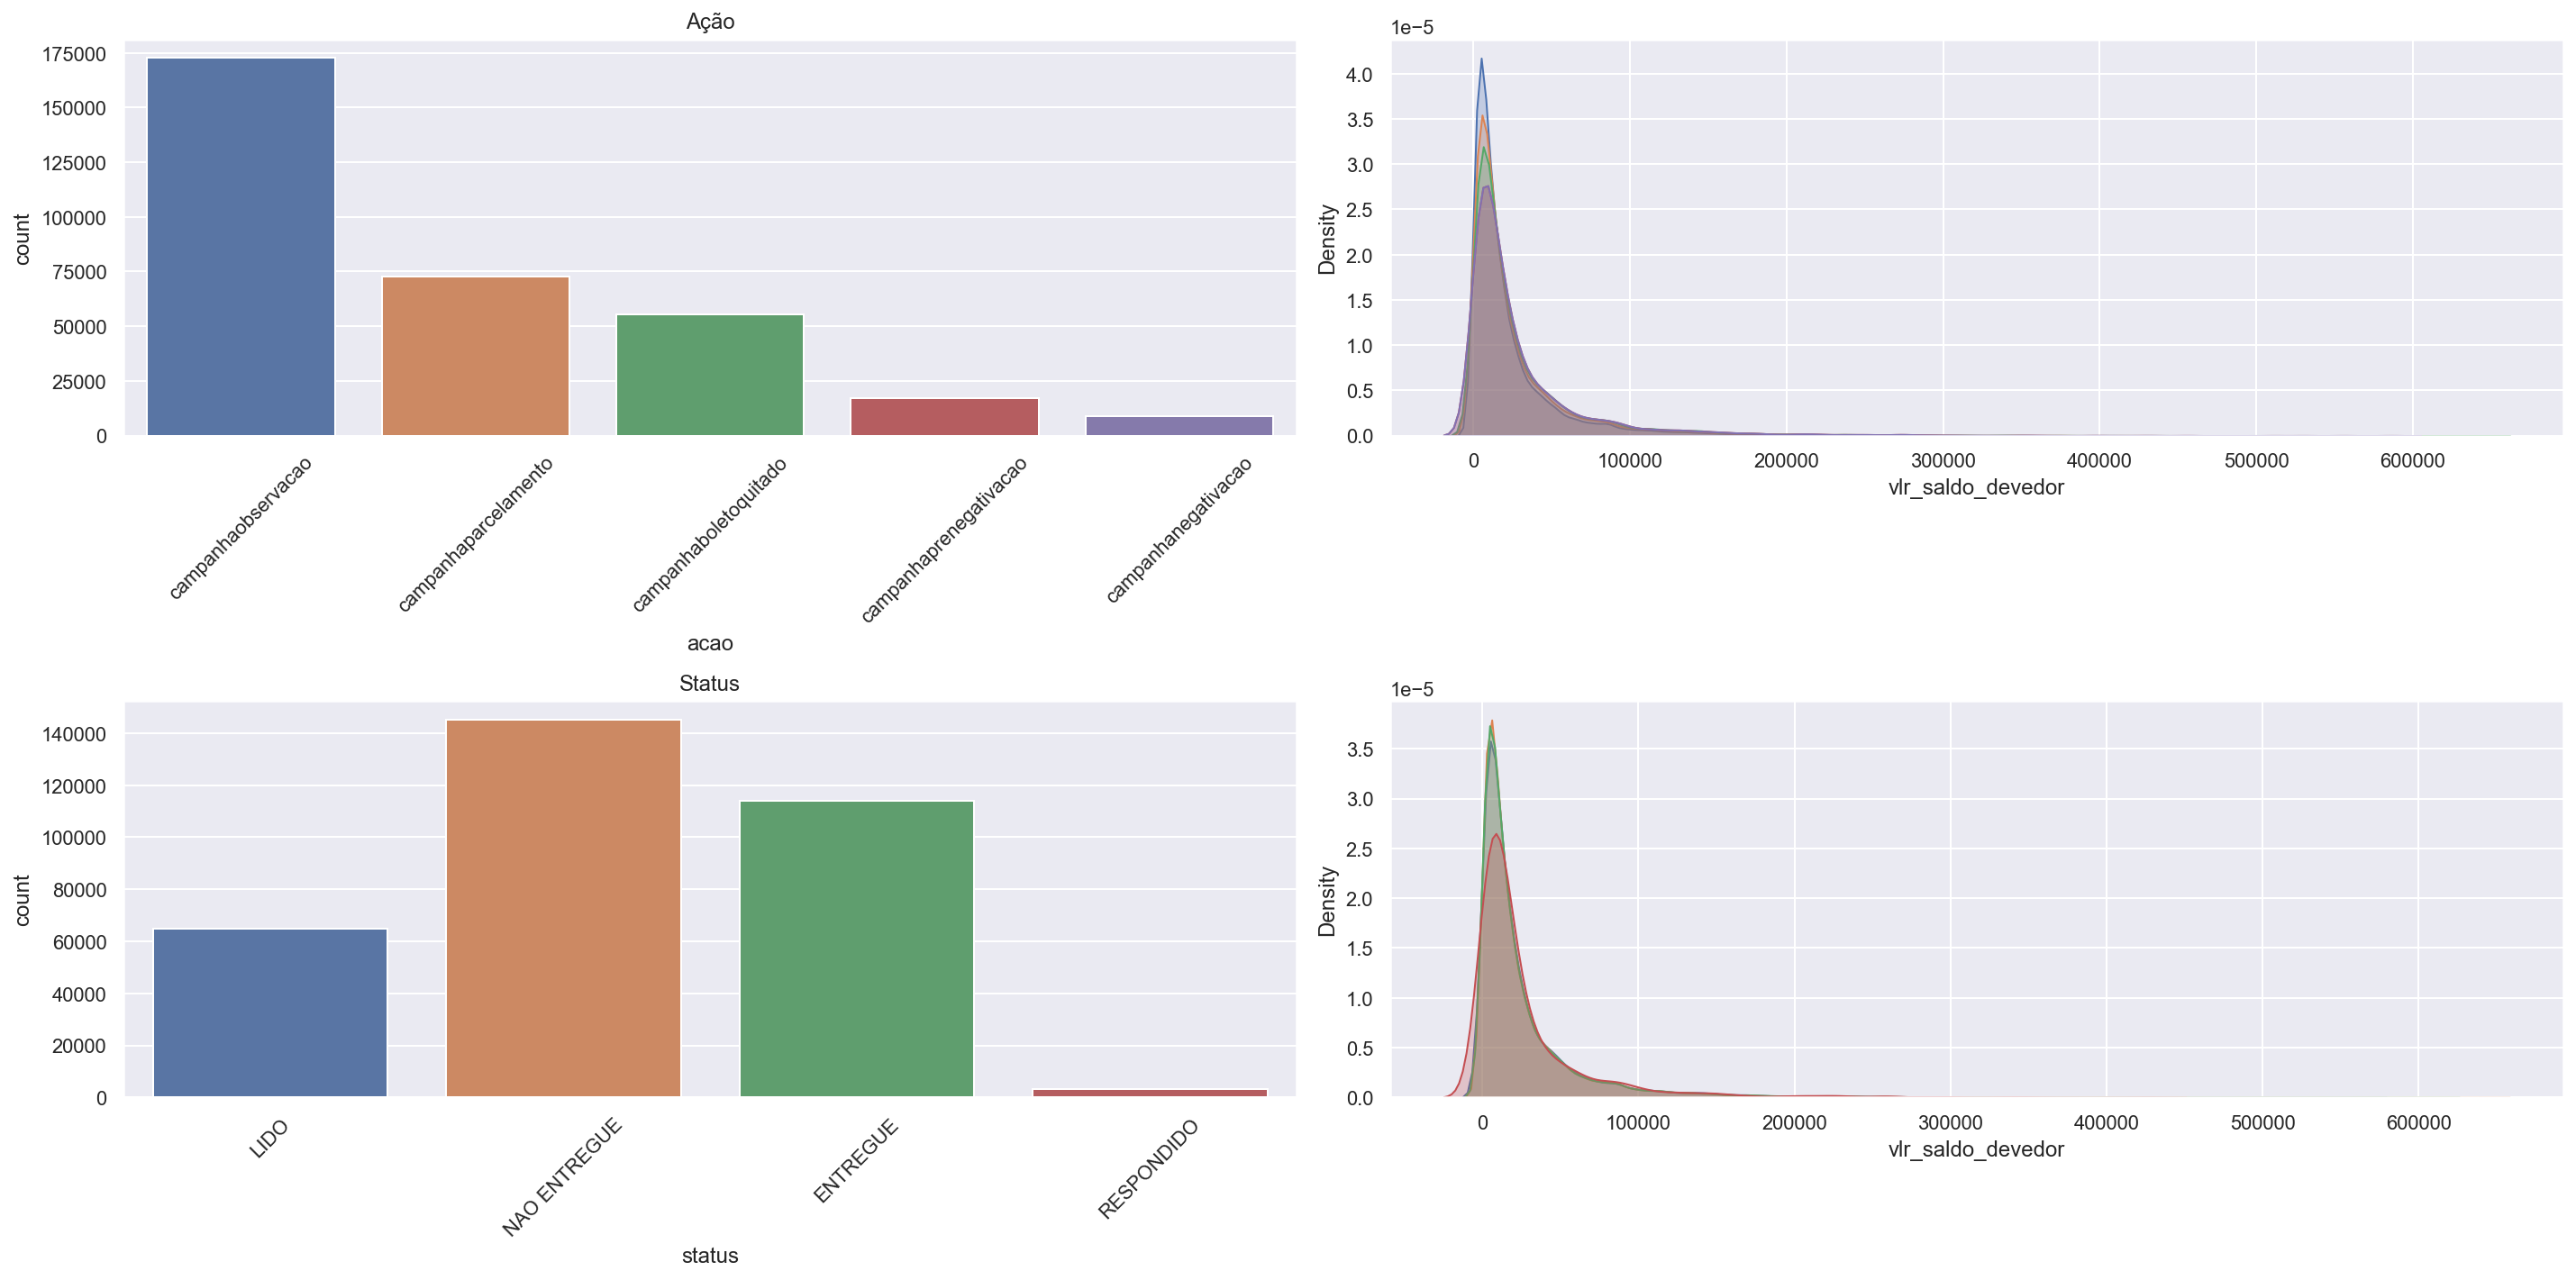

In [8]:
# ação
plt.subplot( 2, 2, 1)
plt.xticks(rotation=45)
plt.title('Ação')
sns.countplot( x = df['acao'] )

plt.subplot( 2, 2, 2)
sns.kdeplot( df[ df['acao'] == 'campanhaobservacao' ]['vlr_saldo_devedor'], label = 'campanhaobservacao', shade=True )
sns.kdeplot( df[ df['acao'] == 'campanhaparcelamento' ]['vlr_saldo_devedor'], label = 'campanhaparcelamento', shade=True )
sns.kdeplot( df[ df['acao'] == 'campanhaboletoquitado' ]['vlr_saldo_devedor'], label = 'campanhaboletoquitado', shade=True )
sns.kdeplot( df[ df['acao'] == 'campanhaprenegativacao' ]['vlr_saldo_devedor'], label = 'campanhaprenegativacao', shade=True )
sns.kdeplot( df[ df['acao'] == 'campanhaprenegativacao' ]['vlr_saldo_devedor'], label = 'campanhaprenegativacao', shade=True )

# status
plt.subplot( 2, 2, 3)
plt.xticks(rotation=45)
plt.title('Status')
sns.countplot( x = df['status'] )

plt.subplot( 2, 2, 4 )
sns.kdeplot( df[ df['status'] == 'LIDO' ]['vlr_saldo_devedor'], label = 'LIDO', shade=True )
sns.kdeplot( df[ df['status'] == 'NAO ENTREGUE' ]['vlr_saldo_devedor'], label = 'NAO ENTREGUE', shade=True )
sns.kdeplot( df[ df['status'] == 'ENTREGUE' ]['vlr_saldo_devedor'], label = 'ENTREGUE', shade=True )
sns.kdeplot( df[ df['status'] == 'RESPONDIDO' ]['vlr_saldo_devedor'], label = 'RESPONDIDO', shade=True )

tight_layout();

## Cálculo Efetividade das ações ( percentual acumulado )
**75% dos contratos voltam a pagar antes de 10 dias**

In [9]:
df_efetividade_acao = df[['acao','contrato_id']].groupby('acao').count().reset_index().sort_values('contrato_id', ascending=False )
df_efetividade_acao['perc_acumulado'] = ( df_efetividade_acao['contrato_id'].cumsum() / df_efetividade_acao['contrato_id'].sum()) * 100
df_efetividade_acao['dias'] = df_efetividade_acao['acao'].apply( lambda x: 5 if x == 'campanhaobservacao' else 10 
                                                            if x == 'campanhaparcelamento' else 15
                                                            if x == 'campanhaboletoquitado' else 30 
                                                            if x == 'campanhaprenegativacao' else 60 
                                                            if x == 'campanhanegativacao' else 90 )
df_efetividade_acao

,acao,contrato_id,perc_acumulado,dias
2,campanhaobservacao,172630,52.8003,5
3,campanhaparcelamento,72868,75.0876,10
0,campanhaboletoquitado,55453,92.0483,15
4,campanhaprenegativacao,17138,97.2901,30
1,campanhanegativacao,8860,100.0000,60


In [11]:
df_efetividade_acao.to_csv('../../datasets/datasets_transformados/abc_acoes.csv')

## DSP x Saldo Devedor / DSPP X Saldo Devedor

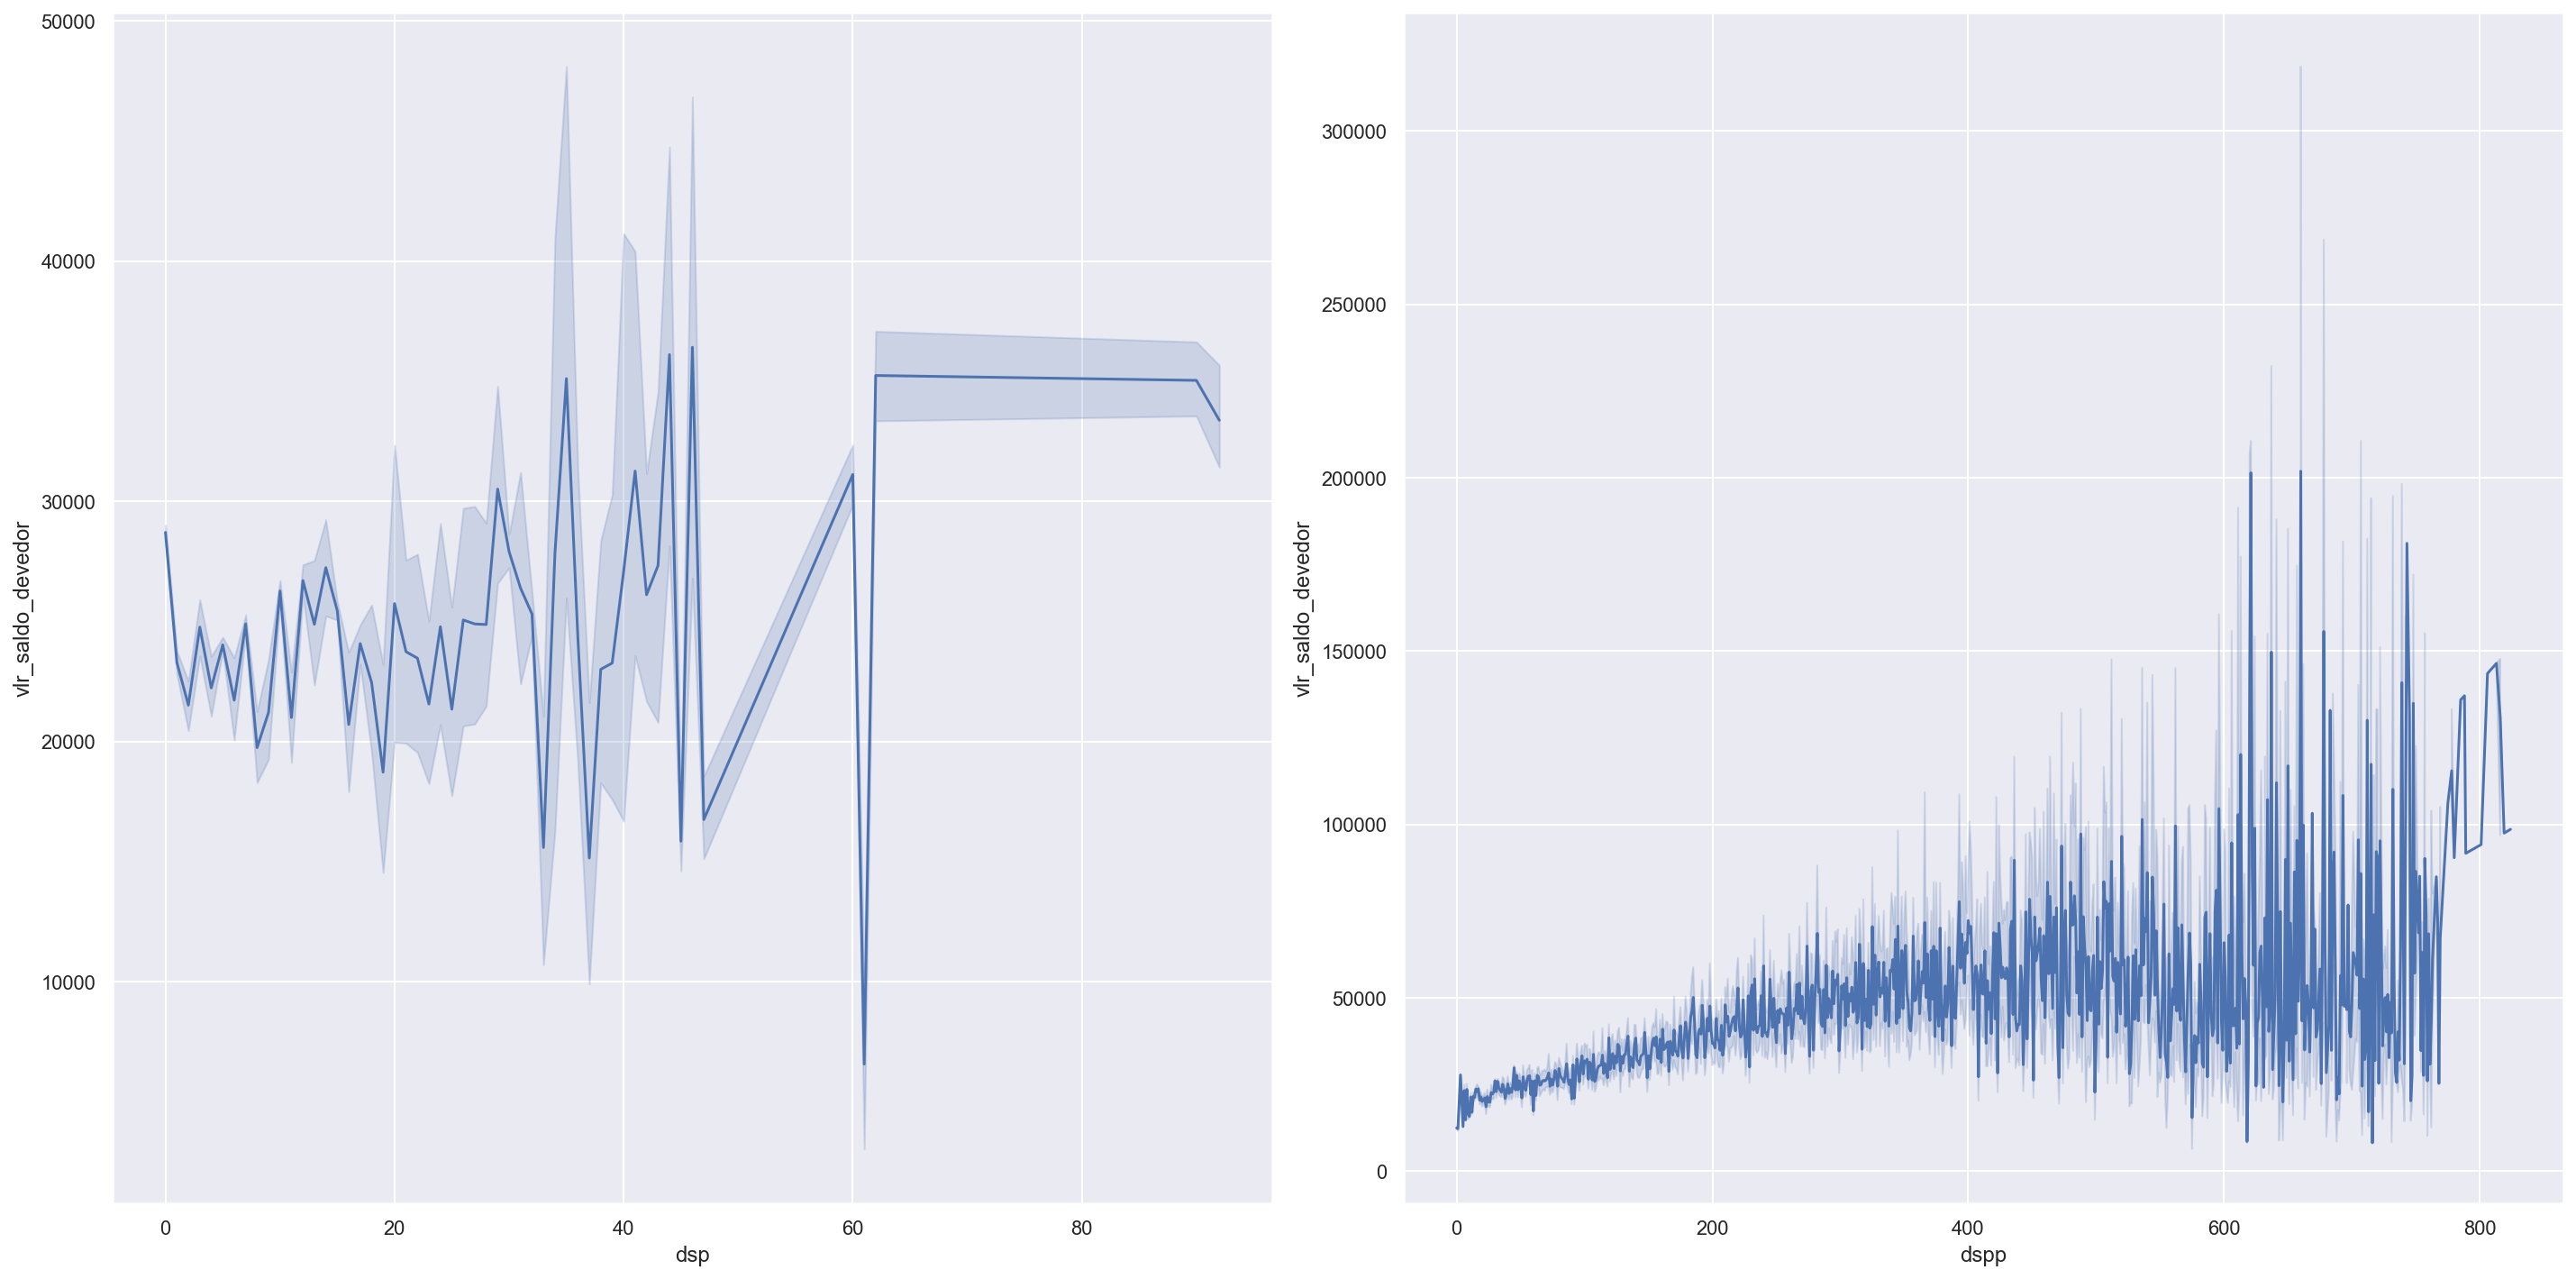

In [10]:
plt.subplot( 1, 2, 1 )
sns.lineplot( x='dsp', y='vlr_saldo_devedor', data=df);

plt.subplot( 1, 2, 2 )
sns.lineplot( x='dspp', y='vlr_saldo_devedor', data=df);
tight_layout();